In [2]:
import numpy as np
import cv2
from skimage import measure
import pyvista as pv
import os

In [3]:
def create_3d_models(image_paths, label_color_map=None):
    """
    Create 3D mesh models for each label from a stack of 2D label images.
    
    Parameters
    ----------
    image_paths : list of str
        A sorted list of file paths pointing to the 2D label images.
        Each image contains integer labels (0 for background, 1–15 for organs).
    label_color_map : dict, optional
        A dictionary mapping label -> color (string or RGB tuple).
        For example: {1: "red", 2: (0, 1, 0), ...}
        If None, default colors will be assigned.

    Returns
    -------
    dict
        A dictionary where:
        - keys are integer labels (1–15)
        - values are dicts containing:
            "mesh": pyvista.PolyData mesh for that label
            "color": color for that label
    """
    # 1) Read all slices and stack into a 3D volume
    volume_slices = []
    for path in image_paths:
        # Read as grayscale or as is (assuming single-channel label images)
        label_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        volume_slices.append(label_img)
    volume = np.stack(volume_slices, axis=0)  # shape: (depth, height, width)
    
    # 2) Prepare output dictionary
    mesh_dict = {}

    # If no label_color_map is provided, define some default colors
    if label_color_map is None:
        default_colors = [
            "red", "green", "blue", "yellow", "magenta", "cyan",
            "orange", "purple", "brown", "pink", "lime", "teal",
            "navy", "olive", "gray"
        ]
        label_color_map = {}
        # Fill color map for labels 1–15
        for lbl in range(1, 16):
            color_index = (lbl - 1) % len(default_colors)
            label_color_map[lbl] = default_colors[color_index]

    # 3) For each label (1–15), extract a surface mesh
    for lbl in range(1, 16):
        # Create a binary mask for the current label
        label_mask = (volume == lbl).astype(np.uint8)
        if np.any(label_mask):
            # Run marching cubes to get vertices and faces
            # The level=0.5 is used to identify boundaries in the binary volume
            verts, faces, normals, values = measure.marching_cubes(
                label_mask, 
                level=0.5, 
                spacing=(1.0, 1.0, 1.0)  # adjust if voxel spacing is different
            )

            # Convert faces from (n, 3) to a format suitable for PyVista
            # PyVista expects [n_vertices_per_face, v1, v2, v3, ...]
            faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int32)
            
            # Create a PyVista PolyData mesh
            mesh = pv.PolyData(verts, faces_pv)

            # Store the mesh along with the color in the dictionary
            mesh_dict[lbl] = {
                "mesh": mesh,
                "color": label_color_map.get(lbl, "white")
            }
        else:
            # If that label doesn't exist in the volume, skip it
            continue

    return mesh_dict

In [4]:
def show_3d_model(mesh_dict, labels_to_show=None, background_color="white"):
    """
    Show an interactive 3D view of the meshes generated for each label.

    Parameters
    ----------
    mesh_dict : dict
        Dictionary returned by create_3d_models.
        Keys = labels, Values = { "mesh": <pyvista.PolyData>, "color": <color> }
    labels_to_show : list of int, optional
        Which labels to show. If None, show all available labels.
    background_color : str or tuple
        Background color for the 3D viewer. Default is "white".
    """
    plotter = pv.Plotter()
    plotter.background_color = background_color

    # If no specific labels are requested, show all
    if labels_to_show is None:
        labels_to_show = list(mesh_dict.keys())

    for lbl, mesh_info in mesh_dict.items():
        if lbl in labels_to_show:
            mesh = mesh_info["mesh"]
            color = mesh_info["color"]
            plotter.add_mesh(
                mesh, 
                color=color, 
                opacity=1.0,  # adjust if you want semi-transparency
                show_edges=False  # set to True to see mesh edges
            )

    plotter.show()

In [8]:
amos_test_label_path = r"D:\Database\Images\amos22 (1)\amos22\Test\label"
ct_names = set([name.split("_")[1] for name in os.listdir(amos_test_label_path)])
print(ct_names)

{'0203', '0233', '0056', '0136', '0140', '0200', '0208', '0150', '0117', '0219', '0073', '0106', '0206', '0087', '0216', '0034', '0167', '0051', '0112', '0191', '0008', '0022', '0202', '0218', '0207', '0257', '0090', '0144', '0120', '0032', '0108', '0258', '0029', '0063', '0244', '0085', '0247', '0204', '0070', '0123', '0250', '0176', '0018', '0228', '0041', '0128', '0238', '0255', '0157', '0278', '0061', '0194', '0174', '0189', '0280', '0013', '0155', '0132', '0223', '0040'}


In [15]:
ct_images = [[name for name in os.listdir(amos_test_label_path) if ct_num in name] for ct_num in ct_names]
ct_images

[['amos_0203_slice0.png',
  'amos_0203_slice1.png',
  'amos_0203_slice10.png',
  'amos_0203_slice100.png',
  'amos_0203_slice101.png',
  'amos_0203_slice102.png',
  'amos_0203_slice103.png',
  'amos_0203_slice104.png',
  'amos_0203_slice105.png',
  'amos_0203_slice106.png',
  'amos_0203_slice107.png',
  'amos_0203_slice108.png',
  'amos_0203_slice109.png',
  'amos_0203_slice11.png',
  'amos_0203_slice110.png',
  'amos_0203_slice111.png',
  'amos_0203_slice112.png',
  'amos_0203_slice113.png',
  'amos_0203_slice114.png',
  'amos_0203_slice115.png',
  'amos_0203_slice116.png',
  'amos_0203_slice117.png',
  'amos_0203_slice118.png',
  'amos_0203_slice119.png',
  'amos_0203_slice12.png',
  'amos_0203_slice120.png',
  'amos_0203_slice121.png',
  'amos_0203_slice122.png',
  'amos_0203_slice123.png',
  'amos_0203_slice124.png',
  'amos_0203_slice125.png',
  'amos_0203_slice126.png',
  'amos_0203_slice127.png',
  'amos_0203_slice128.png',
  'amos_0203_slice129.png',
  'amos_0203_slice13.png',


In [24]:
key = lambda x : int(x.split("_")[-1].replace("slice", "").replace(".png", ""))
sorted_image_paths = []
for ct in ct_images:
    ct.sort(key=key)
    sorted_image_paths.append(ct)

10
[['amos_0203_slice0.png', 'amos_0203_slice1.png', 'amos_0203_slice2.png', 'amos_0203_slice3.png', 'amos_0203_slice4.png', 'amos_0203_slice5.png', 'amos_0203_slice6.png', 'amos_0203_slice7.png', 'amos_0203_slice8.png', 'amos_0203_slice9.png', 'amos_0203_slice10.png', 'amos_0203_slice11.png', 'amos_0203_slice12.png', 'amos_0203_slice13.png', 'amos_0203_slice14.png', 'amos_0203_slice15.png', 'amos_0203_slice16.png', 'amos_0203_slice17.png', 'amos_0203_slice18.png', 'amos_0203_slice19.png', 'amos_0203_slice20.png', 'amos_0203_slice21.png', 'amos_0203_slice22.png', 'amos_0203_slice23.png', 'amos_0203_slice24.png', 'amos_0203_slice25.png', 'amos_0203_slice26.png', 'amos_0203_slice27.png', 'amos_0203_slice28.png', 'amos_0203_slice29.png', 'amos_0203_slice30.png', 'amos_0203_slice31.png', 'amos_0203_slice32.png', 'amos_0203_slice33.png', 'amos_0203_slice34.png', 'amos_0203_slice35.png', 'amos_0203_slice36.png', 'amos_0203_slice37.png', 'amos_0203_slice38.png', 'amos_0203_slice39.png', 'amos

C:\Users\parde\miniforge3\envs\AMOS\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


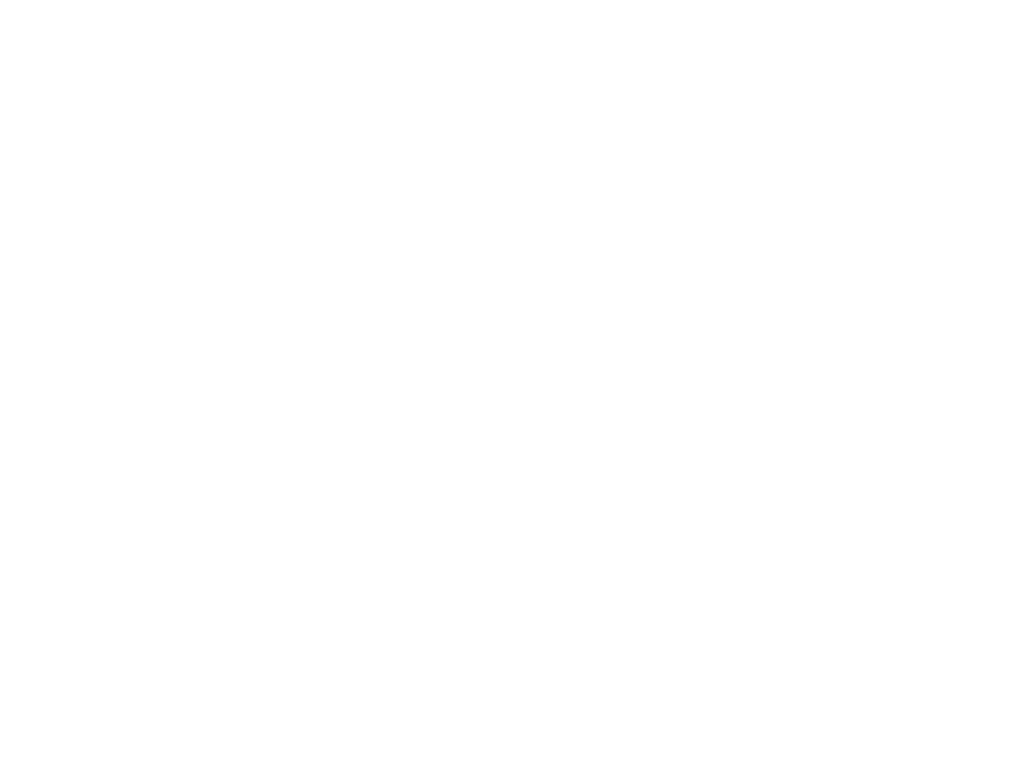

In [26]:

# 2) (Optional) Define a custom color map for some or all labels
#    Label -> color (string or (r, g, b) in [0,1])
# organ_colors = {
#     1: "red",
#     2: "green",
#     3: "blue",
#     4: "yellow",
#     5: (0.5, 0, 0.5),   # purple in RGB
#     # ...
# }

# 3) Generate the 3D mesh dictionary
organ_colors = None
sorted_single_ct_images = sorted_image_paths[0]
meshes = create_3d_models(sorted_single_ct_images, label_color_map=organ_colors)

# 4) Show the 3D scene, e.g. only labels 1, 2, and 5
show_3d_model(meshes, labels_to_show=[1, 2, 5])
